# K-Means clustering

The k-means clustering algorithm is very simple:

1. Choose $k$ random points in $\mathbb R^n$ (the feature space) 
2. Compute the Euclidean distance between data-points and the random centroids. 
3. Label each data-point with the closest centroid
4. Move the centroid to the center of mass of each cluster. If no swapping occurs, terminate

## Data to cluster

In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import numpy as np
import matplotlib.pyplot as plt

In [408]:
np.random.seed(42)
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
def plot(data, labels=None):
    if labels is None:
        plt.scatter(data[0][:, 0],data[0][:,1], c=data[1])
    else:
        plt.scatter(data[0][:, 0],data[0][:,1], c=labels)

Let's start simple and work with blobs:

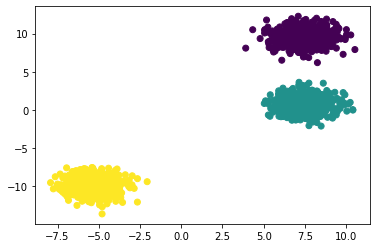

In [409]:
plot(blobs)

## Implementation

In [410]:
from collections import defaultdict
import pandas as pd # For cheating

def dict_groupby(keys, vals):
    mean = defaultdict(int)
    for key, val in zip(keys, vals):
        mean[key] += val/len(keys)
    return dict(mean)

In [411]:
def k_means(data, k, max_iter=50):
    num_feats = data.shape[1]
    centroids = np.random.uniform(low=data.min(), high=data.max(), size=(k, num_feats))
    cluster = {}
    centroid_history = [] # For visualization
    for _ in range(max_iter):
        for feature_idx, feature in enumerate(data):
            dists = []
            for center_idx in range(0, k):
                dists.append(np.linalg.norm(centroids[center_idx, :]-feature))
            cluster[feature_idx] = np.argmin(dists)
        centroids_ = pd.DataFrame(data).groupby(by=cluster).mean().values
        if centroids_.shape != (k, num_feats):
            # We randomly left a cluster unlabelled, reinitialize or randomly put in the missing label
            centroids_ = np.random.uniform(low=data.min(), high=data.max(), size=(k, num_feats))
        if np.array_equal(centroids, centroids_):
            print(f"Completed after {_} iterations")
            centroid_history.append(centroids_)
            break
        else:
            centroids = centroids_
            centroid_history.append(centroids)
    return centroids, np.array(list(cluster.values())), centroid_history

In [412]:
centroids, clusters, centroid_history = k_means(blobs[0], 3)

Completed after 5 iterations


Let's plot the centroids and label the data with the computed cluster index:

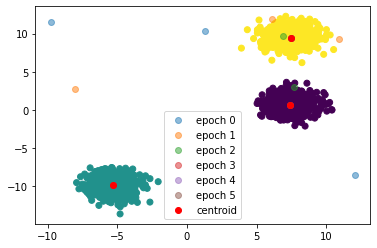

In [415]:
plt.figure()
plot(blobs, labels=clusters)
for i, centroid_ in enumerate(centroid_history):
    plt.scatter(x=centroid_[:, 0], y=centroid_[:, 1], alpha=0.5, label=f"epoch {i}")
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], c='r', label="centroid")
plt.legend()

## Determining the optimal k

The biggest weakness of k-means clustering is the fact that k must be set by the user. This can make the problem a non-starter for complex datasets where the practitioner has no good reason to choose say a large k over a small k.

In [416]:
def cost(data, centroids, cluster):
    sum_ = 0
    for i, val in enumerate(data):
        sum_ += np.sqrt((centroids[int(cluster[i]), 0]-val[0])**2 +(centroids[int(cluster[i]), 1]-val[1])**2)
    return sum_


cost_list = []
for k in range(1, 10):
    centroids, cluster, _ = k_means(blobs[0], k)
    cost_list.append(cost(blobs[0], centroids, cluster))

Completed after 1 iterations
Completed after 1 iterations
Completed after 3 iterations
Completed after 12 iterations
Completed after 17 iterations
Completed after 14 iterations


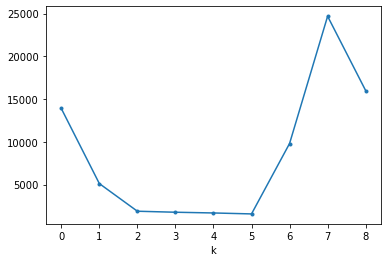

In [422]:
plt.plot(cost_list, '.-')
plt.xlabel('k');

We see that there is plateau in the cluster sum of squares in the interval $k\in[2, 5]$. Being completely unaware of what the data actually looks like, we would reasonably have picked 3.